# Build Network Graph
Borrowed code from the earlier notebooks

In [214]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
import warnings
import random # NEW! For Agents
warnings.filterwarnings('ignore', category=UserWarning)

np.random.seed(99) # Set random seed for reproducibility
random.seed(99)

df = pd.read_csv('../data/bilat_mig.csv')# Load the migration data
# Rebuild the directed graph
G = nx.DiGraph()
for index, row in df.iterrows():
    if row['da_pb_closed'] > 0:
        G.add_edge(row['orig'], row['dest'], weight=row['da_pb_closed'])
print("Libraries loaded and graph rebuilt successfully!")
print(f"Graph: {G.number_of_nodes()} countries, {G.number_of_edges()} migration flows")

Libraries loaded and graph rebuilt successfully!
Graph: 10 countries, 88 migration flows


## Test Traversing Graph
Test of different ways you can set parameters onto nodes.\
Can be used later to set GDP ect.\
If you add a parameter to one node the other nodes all remain empty.

In [215]:
print(G.nodes)

# Set node parameters
G.nodes["USA"]["GDP"] = 1000

# Test retrieving data
print(G.nodes["USA"]["GDP"])

# Error if not set yet. Parameters are node-by-node
try:
    print(G.nodes["IND"]["GDP"])
except KeyError:
    print("Parameter not found")


# Test looping
for node_name, node_dict in G.nodes(data=True):
    print(node_name)
    node_dict["TEST"] = 100

# Test retrieval
print(G.nodes["USA"]["TEST"])



# Test retrieving random
random_node_name = random.choice(list(G.nodes))
print("Random Node:", random_node_name, G[random_node_name])

['IND', 'PHL', 'POL', 'GBR', 'DEU', 'MEX', 'CAN', 'USA', 'AUS', 'SYR']
1000
Parameter not found
IND
PHL
POL
GBR
DEU
MEX
CAN
USA
AUS
SYR
100
Random Node: CAN {'PHL': {'weight': 59301.84}, 'IND': {'weight': 57478.78}, 'SYR': {'weight': 4915.33}, 'POL': {'weight': 25385.39}, 'GBR': {'weight': 77752.27}, 'DEU': {'weight': 87524.87}, 'MEX': {'weight': 13931.96}, 'USA': {'weight': 217331.25}, 'AUS': {'weight': 13750.14}}


# Modelling
## Agent Setup
Start with a simple agent that can traverse a networkX network.\
Uses template from wk 7 Lab.\
Agents will have all the attributes for a single person, as well as their decision making methods.

### Cost Functions

Runs using two cost functions.\
**check_if_move** tests if the agent even wants to move\
**check_where_move** tests where the agent would go if it does want to move.

NOTE: This is not the only way of doing this. You could have one cost function that tests the likelihood of moving to a specific, rather than general likelihood of moving

### Other Notes

Display gives the option to turn off print statements later.


TO DO:\
Swap random check_move for something more robust\
Replace getting a random new position with graph based

You could definitely combine Move() and Checkmove()

In [216]:
class Agent:
    """
    Summary of main attributes:
    id              - The "name" of this agent
    birth_place     - The source of this agent
    living_place    - The current living place
    job             - Fill later
    age             - Fill later
    wanderlust      - threshold to move per step
    locations       - A list of all locations lived in. If it doesn't move, a duplicate is added
    """
    

    def __init__(self, id, birth_node):
        """Creates a new agent at the given location."""
        self.birth_place = birth_node
        self.living_place = birth_node
        self.job = "Builder"
        self.age = 0
        self.wanderlust = 0.3
        self.id = id
        self.locations = []

    # ------ Cost Functions -------
    def check_if_move(self, world):
        """
        First cost function. Check if current living conditions make it worth moving.
        World currently unused but likely in future iterations.
        Returns either true or false.
        """
        if(random.random() < self.wanderlust):
            return True
        else:
            return False

    def check_where_move(self, world):
        """
        Second cost function. If this agent moves, where would it move to?
        Returns a new connected location        
        """

        # Check valid neighbours
        possible_countries = world.get_neighbours(self.living_place)
        # print("Possible Countries:", list(possible_countries))

        # Get a random one for now
        new_country = random.choice(list(possible_countries))

        return new_country
    


    def step(self, world, display=False):
        self.age += 1

        if(self.check_if_move(world)):
            new_country = self.check_where_move(world)

            # Printouts
            if(display): 
                print("Checking", self.id, 
                "... I live in ", self.living_place, 
                "and I hate it. I'm moving to:", new_country)
        
        else:
            new_country = self.living_place

            # Printouts
            if(display): 
                print("Checking", self.id, 
                "... I live in ", self.living_place, 
                "and I'm happy here")
            
        
        # Add the new location to the array
        self.living_place = new_country
        self.locations.append(new_country)

# Natural Disasters / War

Both natural disasters and war are large events that affect almost all people within a country.\
Here they are modelled as random "Events". In the real world these events are not random, and have identifiable traits in the leadup to an event.\

Type: Currently either "War" or "Natural Disaster"\
No functional difference currently but can be exteneded in the future.

Severity: The size of the negative modifier

Extent: How many people does this affect in the country. As represented by a percentage of people.\
This is not a perfect representation as disasters and war are usually localised on a single city, but we don't have the capacity to model that under the current setup.

Duration: How many steps the event lasts

Age: How long it's gone for




NOTE:
When looping, must be world_graph.nodes to get the node object, not just the name

In [217]:
class World:

    # --------------------------
    # --- NEW: Updated Init ---
    # --------------------------
    def __init__(self, world_graph):
        # Add list of agents
        self.agents      = []

        # Add the world graph
        self.world_graph = world_graph

        # --- NEW: Initialise the event lists. Start with nothing ---
        for node in world_graph.nodes:
            # print(node)
            # Edit the actual node object, not the string name
            self.get_node(node)["event"] = None

    def get_node(self, node_name):
        """Retrieve the actual node object rather than name. Allows editting and retrieval of node parameters."""
        return self.world_graph.nodes[node_name]

    def get_rand_country(self):
        random_item = random.choice(list(self.world_graph.nodes))
        return random_item
    
    def get_neighbours(self, node):
        """Convenience method that looks neater"""
        return self.world_graph.neighbors(node)

    def add_agent(self):
        new_id = len(self.agents) + 1
        rand_birth_place = self.get_rand_country()
        new_agent = Agent(new_id, rand_birth_place)

        print("Adding new agent born in ", rand_birth_place)
        self.agents.append(new_agent)

    def get_agents(self):
        return self.agents
    



    # --------------------------
    # --- NEW: Event methods ---
    # --------------------------

    def check_event(self, node):
        """
        If there's no currently active event, check if one starts.
        If there is an event, check if it ends.
        """
        event_chance = 0.1 # just a static threshold for now

        if(not self.get_event(node)):
            # There's no event yet. check if one starts
            if(random.random() < event_chance):
                # If random chance is met
                type = random.choice(["war", "natural disaster"])
                severity =  10000000             # Some huge happiness penalty
                extent =    1                    # 100% of population
                duration = random.randint(1, 3)       # Between 1 and 3 steps

                self.add_event(node, type, severity, extent, duration)
        # There's an event. Check if it's over
        else:
            # Update the age
            self.get_event(node)["age"] += 1
            # If duration is met
            if(self.get_event(node)["age"] >= self.get_event(node)["duration"]):
                print("Event ended at", node)
                self.remove_event(node)

    def add_event(self, node, type, severity, extent, duration):
        """Helper method. Retrieve the event structure"""
        new_event = {"type"         : type, 
                    "severity"     : severity,
                    "extent"       : extent,
                    "duration"     : duration,
                    "age"          : 0}
        
        self.get_node(node)["event"] = new_event

        print("Event started at", node, "! - ", new_event)
        
    def remove_event(self, node):
        """Helper method. Set the event for a node to be None"""
        self.get_node(node)["event"] = None


    def get_event(self, node):
        """Helper method. Retrieve the event array"""
        return self.get_node(node)["event"]
    


    # --------------------------
    # --- NEW: Updated Step method ---
    # --------------------------

    def step(self):

        # --- NEW: Update Events ---
        for node in self.world_graph.nodes:
            self.check_event(node)

        for agent in self.agents:
            agent.step(self, display=True) # Give the whole object so it can decision make

In [218]:
# Configure new world
world = World(G)

# Add 3 agents
world.add_agent()
world.add_agent()
world.add_agent()

# Run 5 generations and see where they end up
for step in range(5):
    print("----- Generation", step, "-----")
    world.step()

    # # ask the agents again
    # for agent in world.get_agents():
    #     print("Hi, I'm", agent.id,"and I live in", agent.living_place)
    
    print("------------------------")


# Check the route for each agent
print("Born |   0  |   1  |   2  |   3  |   4  |")
for agent in world.get_agents():
    print("  ", agent.id, agent.locations)

Adding new agent born in  CAN
Adding new agent born in  GBR
Adding new agent born in  SYR
----- Generation 0 -----
Checking 1 ... I live in  CAN and I'm happy here
Checking 2 ... I live in  GBR and I hate it. I'm moving to: MEX
Checking 3 ... I live in  SYR and I'm happy here
------------------------
----- Generation 1 -----
Event started at MEX ! -  {'type': 'war', 'severity': 10000000, 'extent': 1, 'duration': 1, 'age': 0}
Event started at SYR ! -  {'type': 'war', 'severity': 10000000, 'extent': 1, 'duration': 3, 'age': 0}
Checking 1 ... I live in  CAN and I'm happy here
Checking 2 ... I live in  MEX and I'm happy here
Checking 3 ... I live in  SYR and I hate it. I'm moving to: DEU
------------------------
----- Generation 2 -----
Event ended at MEX
Checking 1 ... I live in  CAN and I'm happy here
Checking 2 ... I live in  MEX and I'm happy here
Checking 3 ... I live in  DEU and I'm happy here
------------------------
----- Generation 3 -----
Event started at IND ! -  {'type': 'war',

# Test Mapping Code
## Display where events are occuring

{'type': 'war', 'severity': 10000000, 'extent': 1, 'duration': 3, 'age': 0}


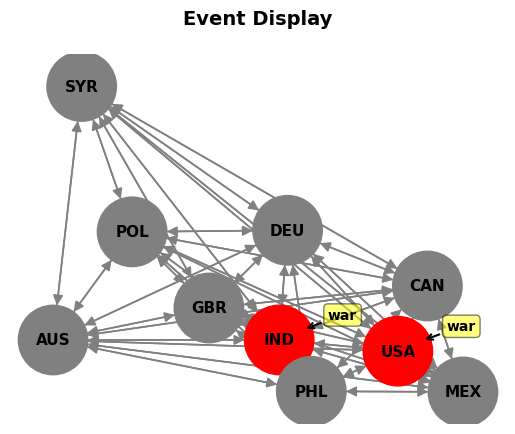

In [219]:
print(world.get_node("USA")["event"])

pos = nx.spring_layout(world.world_graph, k=2, iterations=50, seed=99) # Create spring layout again for consistent node positions

# Build event based colouring:
node_colours = []
for node in world.world_graph.nodes:
    if(world.get_node(node)["event"]):
        # If there's an event
        node_colours.append('Red')
        
        # Also add an annotation
        x, y = pos[node]

        plt.annotate(
        world.get_node(node)["event"]["type"],
        xy=(x+0.05, y+0.05),                  # Pointing to the node. Slight offset
        xytext=(x + 0.1, y + 0.1),  # Position of text box (adjust for your graph)
        textcoords='data',
        bbox=dict(boxstyle="round,pad=0.3", fc="yellow", alpha=0.5),  # callout box style
        arrowprops=dict(arrowstyle="->", color="black", lw=1.5),
        fontsize=10,
        fontweight='bold'
    )
    else:
        node_colours.append('Gray')

# Build agent population based size
# node_sizes = [total_migration[node]/500 for node in G.nodes()]

# nx.draw(world.world_graph, pos, with_labels=True, node_color=node_colors, cmap='YlOrRd', node_size=2500, font_size=11, font_weight='bold', arrows=True, arrowsize=15, edge_color='gray', width=1.2, vmin=0, vmax=1)
nx.draw(world.world_graph, pos, with_labels=True, cmap='YlOrRd', node_color=node_colours, node_size=2500, font_size=11, font_weight='bold', arrows=True, arrowsize=15, edge_color='gray', width=1.2)



plt.title("Event Display\n", fontsize=14, fontweight='bold')
plt.show()